# Modified Neural Network on MNIST Dataset

In [1]:
#Load the dataset
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [2]:
#Import the dataset and other python libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import struct
from array import array
from os.path import join

In [3]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)
    
# Set file paths based on added MNIST Datasets
input_path = '../input'
training_images_filepath = join(input_path, 'mnist-dataset/train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'mnist-dataset/train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 'mnist-dataset/t10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 'mnist-dataset/t10k-labels.idx1-ubyte')

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


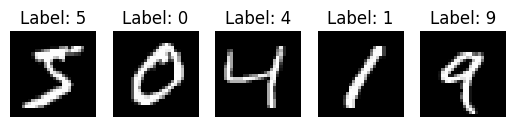

In [4]:
# Display a few images from the training set
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()

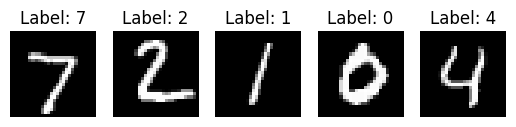

In [5]:
# Display a few images from the testing set
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')

plt.show()

In [6]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
        self.bias = None
        self.zeta = None
        self.z = None 

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

Forward propagation for each layer

        #Z(i) = 0.2 * [{j=1to J} δ ((200 b (j, i) - 100) * (y(j) -  ζ (j, i))) - J + 5] 
        
        #y(i) = ReLU (Zi)
        
Backward Propagation for each layer:

    #β(i,k) = 0.2 *  δ' [(200 b(i, k) - 100) (yi - ζ (i , k))] * (200 b(i,k) - 100)

    #θ (i, k) = 0.2 *  δ' [(200 b(i, k) - 100) (yi - ζ (i , k))] * 200 * (yi - ζ (i, k))

    #∇ b(i, k) =  { (yk – tk) * θ (i, k)}, if z(k) > 0 

    #∇ b(i, k) =  { 0 }, if z(k) < 0 

Questions:

1)	During the Backproagation, the Thresold gradient of the last layer is used. Do we need to accumulate it for all the samples and layer like:
self.prev_zeta_gradient += zeta_gradient

Or do we just need it for the previous layer?
self.prev_zeta_gradient = zeta_gradient


2)	During the backpropagation, we need ReLu prime/ ReLu derivative like in normal NN? 
Currently it is being used. If the input to ReLU is positive, the derivative is 1; if the input is negative, the derivative is 0. This derivative is multiplied by the gradient of the loss with respect to the output of the ReLU layer.

3)	/tmp/ipykernel_33/912799544.py:11: RuntimeWarning: overflow encountered in exp
  	sig = 1 / (1 + np.exp(-alpha * x))

Observations:

•Transposed the self.z to adjust with the shapes of bias and thau.
oEither need to change the shape of the output or the thau to make them compatible during calculation.
oIf I do not transpose the self.z during the output, then for the next layers, incompatible operands error occur during the forward propagation while doing: self.input - self.zeta 
oValueError: operands could not be broadcast together with shapes (50,1) (10,50) 
shape of self.z:  (50, 1)
shape of input_size:  (50, 1)
shape of self.zeta:  (10, 50)
shape of self.bias:  (10, 50)

•If the shape of the output is changed by making it self.z.T, then during the error calculation, need to change the shape of the y_train as well.

In [7]:
# inherit from base class Layer: Fully connected layer code
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
#         print('input_size: ', input_size)
#         print('output_size: ', output_size)
        
         # Initialize zeta based on the layer's position
#         if input_size == 784:  # First layer
#             self.zeta = np.random.rand(1, input_size) - 0.5
#             self.bias = np.random.rand(1, input_size) - 0.5
#         else:  # Subsequent layers
#             self.zeta = np.random.rand(input_size, output_size) - 0.5
#             self.bias = np.random.rand(input_size, output_size) - 0.5

        self.zeta = np.random.rand(output_size, input_size) - 0.5
        self.bias = np.random.rand(output_size, input_size) - 0.5
#         self.prev_zeta_gradient = np.zeros_like(input_size)
       

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
#         print('type of input_size: ', type(input_data))
        print('shape of input_size: ', input_data.shape)
#         print('type of self.zeta: ', type(self.zeta))
        print('shape of self.zeta: ',self.zeta.shape)
#         print('type of self.bias: ',type(self.bias))
        print('shape of self.bias: ',self.bias.shape)
        self.z = 0.2 * (np.sum(sigmoid((200 * self.bias - 100) * (self.input - self.zeta)) - self.output_size + 5, axis = 1, keepdims=True))
        self.output =  self.z.T
        print('shape of self.z: ',self.output.shape)
#         print('self.z: ',self.z)
        return self.output

    
    # computes thresholds - zeta, zeta_gradient and bias_gradient
    def backward_propagation(self, is_last_layer, layer_target_output, prev_zeta_gradient):
        #calculate the beta and theta for the previous layer
        beta = 0.2 * sigmoid_prime((200 * self.bias - 100) * (self.input - self.zeta)) * (200 * self.bias - 100)
        theta = 0.2 * sigmoid_prime((200 * self.bias - 100) * (self.input - self.zeta)) * 200 * (self.input - self.zeta)

#         print('Shape of prev_zeta_gradient before any calculation:', self.prev_zeta_gradient.shape)
        
        
#         print('type of layer_target_output: ', type(layer_target_output))
#         print('shape of layer_target_output: ',layer_target_output.shape)
        print('Shape of beta from BP:', beta.shape)
        print('Shape of theta from BP:', theta.shape)
#         print('type of self.output from BP: ', type(self.output))
        print('shape of self.output from BP: ',self.output.shape)
#         print('shape of layer_target_output from BP: ',layer_target_output.shape)

        if is_last_layer:
            zeta_gradient = np.where(self.z > 0,np.dot((layer_target_output - self.output) , beta), 0)
            bias_gradient = np.where(self.z > 0,np.dot((self.output - layer_target_output) , theta), 0)
            print('shape of zeta_gradient from the is_last_layer statement: ',zeta_gradient.shape)
            print('shape of bias_gradient from the is_last_layer statement: ',bias_gradient.shape)
        else:
            np_sum = np.sum(prev_zeta_gradient, axis=0)
            zeta_gradient = np.where(self.z > 0, np.dot(np.sum(prev_zeta_gradient, axis=0), beta), 0)
            bias_gradient = np.where(self.z > 0, np.dot(np.sum(prev_zeta_gradient, axis=0), -theta), 0)
            print('shape of zeta_gradient from the else statement: ',zeta_gradient.shape)
            print('shape of bias_gradient from the else statement: ',bias_gradient.shape)
    
        prev_zeta_gradient = zeta_gradient
#         print('Shape of prev_zeta_gradient after calculation:', prev_zeta_gradient.shape)
       
        # update parameters
        self.bias = self.bias + bias_gradient
        self.zeta = self.zeta + zeta_gradient
#         print('self.bias from BP: ',self.bias)
#         print('self.zeta from BP:  ',self.zeta)
        return prev_zeta_gradient

In [8]:
# inherit from base class Layer: Activation Layer code
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        super().__init__()
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        #y(i) = ReLU (Zi)
        self.output = self.activation(self.input)
        return self.output

    # Not returning anything for the modified NN
    def backward_propagation(self, is_last_layer, layer_target_output, prev_zeta_gradient):
        _ = self.activation_prime(self.input)
        return prev_zeta_gradient

In [9]:
# updated activation function and its derivative
def ReLU(x):
    return np.maximum(0, x)

def ReLU_prime(x):
    return np.where(x > 0, 1, 0)

# Modified Sigmoid activation function and its derivative
def sigmoid(x, alpha=5):
    x = x.astype(float)
    sig = 1 / (1 + np.exp(-alpha * x))
    #print ('shape of sigmoid function: ', sig.shape)
    return sig

def sigmoid_prime(x, alpha=5):
    return alpha * sigmoid(x, alpha) * (1 - sigmoid(x, alpha))

In [10]:
# loss function and its derivative
# def mse(y_true, y_pred):
#     print ('shape of y_true: ', y_true.shape)
#     print ('shape of y_pred: ', y_pred.shape)
#     return np.mean(np.power(y_true-y_pred, 2));

def mse(y_true, y_pred):
    return np.mean(np.power(np.squeeze(y_true) - np.squeeze(y_pred), 2))
    
def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [11]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
                print ('output from predict :' ,output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        prev_zeta_gradient = None
        samples = len(x_train)
#         print('type of y_train: ', type(y_train))
#         print('shape of y_train: ',y_train.shape)

        # training loop
        for i in range(epochs):
#             print('Epoch ', i)
            err = 0
            for j in range(samples):
                print('Sample ', j)
#                 print('type of y_train[j]: ', type(y_train[j]))
#                 print('shape of y_train[3]: ',y_train[3].shape)
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
#                     print('forward_propagation for ', layer)
                    output = layer.forward_propagation(output)

                #compute loss (for display purpose only)
#                 print ('y_train: ', y_train.shape)
#                 print ('y_train[j]: ', y_train[j].shape)
#                 print ('y_train[1]: ', y_train[1].shape)
                err += self.loss(y_train[j], output)
                
                #compute error for the back propagation
                error = self.loss_prime(y_train[j], output)

                #backward propagation
                for layer in reversed(self.layers):
#                     print('backward_propagation for ', layer)
#                     print(layer)
                    is_last_layer = (layer == self.layers[-2])  # Check if it's the last layerindex
#                     print("is_last_layer:", is_last_layer)
                    prev_zeta_gradient = layer.backward_propagation(is_last_layer, y_train[j], prev_zeta_gradient)
                    
            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

In [12]:
from keras.utils import to_categorical

# training data : 60000 samples
# Convert x_train and x_test to NumPy array
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255

# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255

# encode test output which is a number in range [0,9] into a vector of size 10
#y_test = to_categorical(y_test)

#temp section

# Select the first 1000 samples for training
x_train_subset = x_train[:10]
y_train_subset = y_train[:10]

# Select the first 1000 samples for testing
x_test_subset = x_test[:10]
y_test_subset = y_test[:10]




# test
#out = net.predict(x_test)

2024-03-20 07:57:46.554494: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 07:57:46.554636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 07:57:46.732625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:


# Network with 4 FC layers
net = Network()

net.add(FCLayer(28*28, 50))                # input_shape=(1, 28*28)    ;   output_shape=(1, 50)
net.add(ActivationLayer(ReLU, ReLU_prime))
net.add(FCLayer(50, 50))                   # input_shape=(1, 50)      ;   output_shape=(1, 50)
net.add(ActivationLayer(ReLU, ReLU_prime))
#net.add(FCLayer(50, 50))                   # input_shape=(1, 50)      ;   output_shape=(1, 50)
#net.add(ActivationLayer(ReLU, ReLU_prime))
net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(sigmoid, sigmoid_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train_subset, y_train_subset, epochs=2, learning_rate=0.01)


Sample  0
shape of input_size:  (1, 784)
shape of self.zeta:  (50, 784)
shape of self.bias:  (50, 784)
shape of self.z:  (1, 50)
shape of input_size:  (1, 50)
shape of self.zeta:  (50, 50)
shape of self.bias:  (50, 50)
shape of self.z:  (1, 50)
shape of input_size:  (1, 50)
shape of self.zeta:  (10, 50)
shape of self.bias:  (10, 50)
shape of self.z:  (1, 10)
Shape of beta from BP: (10, 50)
Shape of theta from BP: (10, 50)
shape of self.output from BP:  (1, 10)
shape of zeta_gradient from the is_last_layer statement:  (10, 50)
shape of bias_gradient from the is_last_layer statement:  (10, 50)
Shape of beta from BP: (50, 50)
Shape of theta from BP: (50, 50)
shape of self.output from BP:  (1, 50)
shape of zeta_gradient from the else statement:  (50, 50)
shape of bias_gradient from the else statement:  (50, 50)
Shape of beta from BP: (50, 784)
Shape of theta from BP: (50, 784)
shape of self.output from BP:  (1, 50)
shape of zeta_gradient from the else statement:  (50, 784)
shape of bias_gr

/tmp/ipykernel_33/912799544.py:11: RuntimeWarning: overflow encountered in exp
  sig = 1 / (1 + np.exp(-alpha * x))


Shape of beta from BP: (50, 50)
Shape of theta from BP: (50, 50)
shape of self.output from BP:  (1, 50)
shape of zeta_gradient from the else statement:  (50, 50)
shape of bias_gradient from the else statement:  (50, 50)
Shape of beta from BP: (50, 784)
Shape of theta from BP: (50, 784)
shape of self.output from BP:  (1, 50)
shape of zeta_gradient from the else statement:  (50, 784)
shape of bias_gradient from the else statement:  (50, 784)
Sample  7
shape of input_size:  (1, 784)
shape of self.zeta:  (50, 784)
shape of self.bias:  (50, 784)
shape of self.z:  (1, 50)
shape of input_size:  (1, 50)
shape of self.zeta:  (50, 50)
shape of self.bias:  (50, 50)
shape of self.z:  (1, 50)
shape of input_size:  (1, 50)
shape of self.zeta:  (10, 50)
shape of self.bias:  (10, 50)
shape of self.z:  (1, 10)
Shape of beta from BP: (10, 50)
Shape of theta from BP: (10, 50)
shape of self.output from BP:  (1, 10)
shape of zeta_gradient from the is_last_layer statement:  (10, 50)
shape of bias_gradient f